In [1]:
##This notebook reproduces results of Khemani et al. 2025

#https://arxiv.org/abs/2501.13164

import qutip as qt
from qutip import *

##Qiskit libraries
import qiskit
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import partial_trace
from qiskit.quantum_info import entropy

from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt
import sys
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator

#scipy
import scipy
import itertools
from scipy.special import psi, polygamma
import math

In [3]:
def hlist(N,J,h):
    h_list = [J]
    for i in range(1,N-1):
        h_list.append(h)
    h_list.append(-J)
    return h_list

In [43]:
## We first save the EE data for L = 8,12,14, and then evaluate the EE distribution means and variances


h_list = hlist(N,0.25,h)

def Xp(i,N):  #i goes from 1 to N
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'X'
    for k in range(N-i):
        str1 += 'I'
    return SparsePauliOp(str1)

def Yp(i,N):  #i goes from 1 to N
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'Y'
    for k in range(N-i):
        str1 += 'I'
    return SparsePauliOp(str1)

def Zp(i,N):  #i goes from 1 to N
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'Z'
    for k in range(N-i):
        str1 += 'I'
    return SparsePauliOp(str1)

def ZZp(i,N): #i goes from 1 to N-1
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'ZZ'
    for k in range(N-i-1):
        str1 += 'I'
    return SparsePauliOp(str1)

def YZp(i,N): #i goes from 1 to N-1
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'YZ'
    for k in range(N-i-1):
        str1 += 'I'
    return SparsePauliOp(str1)


def H_tfim(N,g,J,h_list):
    op = 0
    for i in range(1,N):
        op += g*Xp(i,N) + h_list[i-1]*Zp(i,N) + J*ZZp(i,N)
    op+=g*Xp(N,N) + h_list[N-1]*Zp(N,N)
    return op

def index_range(index,width,xvals):
    ##Find  indices of the elements closest to xvals[index] - width and xvals[index] + width
    index1 = np.argmin(np.abs(xvals - (xvals[index] - width)))
    index2 = np.argmin(np.abs(xvals - (xvals[index] + width)))

    #midvecs = eigvecs[:,index1:index2+1]
    return index1,index2

def vn_traced(N,Na,state):
    """
    Function to compute the von Neumann entropy of a state
    INPUT
    state : input state
    Na : number of spins in subsystem A
    RETURN
    S_A : von Neumann entropy of subsystem A
    """
    # Create the reduced density matrix for subsystem A
    trace_out = [i for i in range(state.num_qubits) if i%2 != 0] #non-locAL BIPARTION
    trace_out2 = [i for i in range(N - Na)] #local bipartition
    rho_A = partial_trace(state, trace_out2)
    
    S_A = entropy(rho_A, base=np.e)  # Compute the von Neumann entropy
    
    return S_A

def plot_spectrum_midvecs(midvecs,f,N,a,b,n,Dn):
    Na = int(f*N)
    mean_MF = -Na*(n*np.log(n)  + (1-n)*np.log(1-n)) + (f + np.log(1-f))/2
    ee_list = []
    for i in range(a,b):
        state = Statevector(midvecs[:,i])
        state_fin = Statevector(np.ascontiguousarray(state.data))  #Parses the data as a contiguous array, can be removed if no memory allocation error pops up

        #print("ee_val",vn_traced(N,Na,state_fin))

        ee_list.append(np.real(vn_traced(N,Na,state_fin)))
        
    delta_mean = np.mean(ee_list) - mean_MF
    sigma_norm = np.std(ee_list)*(Dn**2/N)**(0.25)

    return delta_mean,sigma_norm




    
    




In [7]:
op = H_tfim(N,g,J,h_list)
mat_fin = SparsePauliOp.to_matrix(op)

#Evaluate the eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eigh(mat_fin)
np.savetxt(f'mfim_eigvecs_h={h},g={g},N={N}.txt', np.real(eigvecs))
np.savetxt(f'mfim_eigvals_h={h},g={g},N={N}.txt', np.real(eigvals))

In [53]:
##Now, we need to access the 

N = 14
dim = 2**N
f=0.5
J = 1
h = 0.35
g = 1.1
E=1.56 #epsilon*
a_in= -0.5
b_in= 0.5

samples_list = np.linspace(a_in,b_in,100)

width = 0.005*E

eigvals_in = np.loadtxt(f'mfim_eigvals_h={h},g={g},N={N}.txt')
eigvecs_in = np.loadtxt(f'mfim_eigvecs_h={h},g={g},N={N}.txt')

xvals = eigvals_in/(N*E)

#print(len(xvals))

start = np.argmin(np.abs(xvals -a_in))
end = np.argmin(np.abs(xvals - b_in))

dmean_list = []
dstd_list = []

xvals_fin = []

for i in samples_list:
    #find the value of index of x in xvals closest to i

    ind = np.argmin(np.abs(xvals - i))
    x = xvals[ind]
    xvals_fin.append(x)
    n = 0.5*(1 + x)
    Dn = np.exp(-(n*np.log(n) + (1-n)*np.log(1-n))*N)
    a,b = index_range(ind,width,xvals)
    print(a,ind,b)
    delta_mean,sigma_norm = plot_spectrum_midvecs(eigvecs_in,f,N,a,b,n,Dn)
    dmean_list.append(delta_mean)
    dstd_list.append(sigma_norm)

#xvals_fin = xvals[start:end+1]

#column stack the xvals and the mean and std
data = np.column_stack((xvals_fin, dmean_list, dstd_list))
np.savetxt(f'delta_mean_std_h={h},g={g},N={N},f={f}.txt', data)





359 390 422
399 431 469
442 479 515
489 527 567
539 581 623
593 636 684
650 697 747
712 761 815
778 830 888
848 904 964
921 983 1046
1002 1068 1135
1087 1155 1228
1176 1250 1323
1271 1347 1428
1370 1454 1537
1476 1563 1653
1588 1678 1773
1705 1803 1899
1831 1930 2034
1961 2065 2171
2096 2205 2315
2236 2349 2465
2383 2500 2620
2534 2658 2780
2694 2819 2948
2856 2987 3120
3027 3159 3301
3201 3342 3483
3384 3526 3675
3570 3718 3870
3763 3917 4071
3959 4116 4276
4165 4324 4488
4371 4535 4702
4586 4753 4921
4802 4973 5147
5027 5200 5375
5251 5427 5607
5481 5659 5841
5712 5895 6078
5949 6132 6318
6188 6372 6561
6430 6617 6807
6672 6863 7053
6919 7110 7302
7167 7359 7552
7416 7611 7802
7665 7860 8055
7918 8111 8306
8169 8364 8556
8419 8613 8806
8672 8864 9057
8920 9112 9303
9171 9361 9551
9416 9606 9794
9661 9849 10036
9904 10090 10274
10145 10329 10513
10384 10564 10743
10616 10797 10974
10850 11025 11199
11077 11249 11422
11299 11470 11638
11521 11688 11851
11735 11898 12059
11948 12106 122

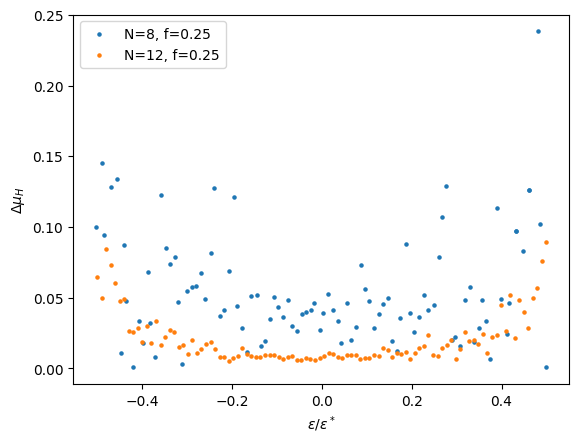

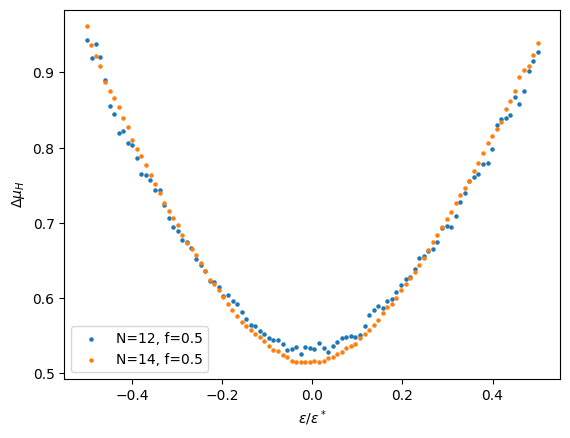

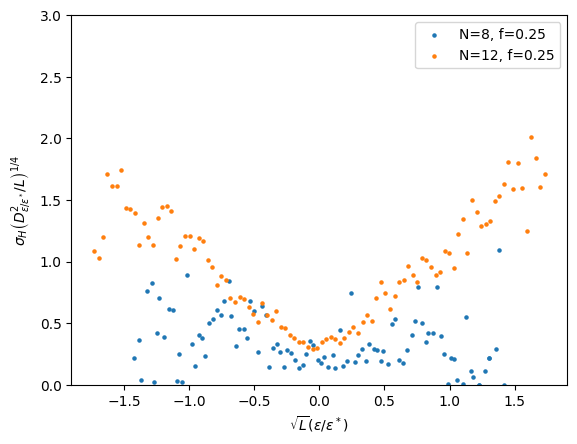

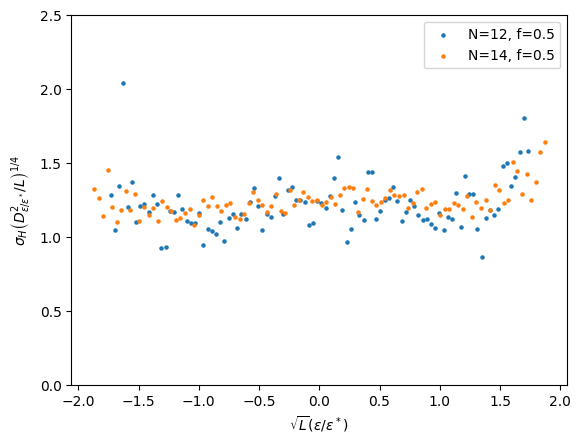

In [61]:
##Let us plot the means and stds

N1 = 8
N2 = 12
N3 = 14

f1 = 0.25
f2 = 0.5

xvals1 = np.loadtxt(f'delta_mean_std_h={h},g={g},N={N1},f={f1}.txt')[:,0]
xvals2 = np.loadtxt(f'delta_mean_std_h={h},g={g},N={N2},f={f1}.txt')[:,0]
xvals3 = np.loadtxt(f'delta_mean_std_h={h},g={g},N={N3},f={f2}.txt')[:,0]

dmean1 = np.loadtxt(f'delta_mean_std_h={h},g={g},N={N1},f={f1}.txt')[:,1]
dmean2 = np.loadtxt(f'delta_mean_std_h={h},g={g},N={N2},f={f1}.txt')[:,1]

dmean3 = np.loadtxt(f'delta_mean_std_h={h},g={g},N={N2},f={f2}.txt')[:,1]
dmean4 = np.loadtxt(f'delta_mean_std_h={h},g={g},N={N3},f={f2}.txt')[:,1]


dstd1 = np.loadtxt(f'delta_mean_std_h={h},g={g},N={N1},f={f1}.txt')[:,2]
dstd2 = np.loadtxt(f'delta_mean_std_h={h},g={g},N={N2},f={f1}.txt')[:,2]

dstd3 = np.loadtxt(f'delta_mean_std_h={h},g={g},N={N2},f={f2}.txt')[:,2]
dstd4 = np.loadtxt(f'delta_mean_std_h={h},g={g},N={N3},f={f2}.txt')[:,2]

plt.scatter(xvals1,np.abs(dmean1), label = f'N={N1}, f={f1}', s=5)
plt.scatter(xvals2,np.abs(dmean2), label = f'N={N2}, f={f1}', s=5)
plt.xlabel(r'$\epsilon/\epsilon^*$')
plt.ylabel(r'$\Delta \mu_H$')
plt.legend()
plt.show()

plt.scatter(xvals2,np.abs(dmean3), label = f'N={N2}, f={f2}', s=5)
plt.scatter(xvals3,np.abs(dmean4), label = f'N={N3}, f={f2}', s=5)
plt.xlabel(r'$\epsilon/\epsilon^*$')
plt.ylabel(r'$\Delta \mu_H$')
plt.legend()
plt.show()

plt.scatter(np.sqrt(N1)*xvals1,np.abs(dstd1), label = f'N={N1}, f={f1}', s=5)
plt.scatter(np.sqrt(N2)*xvals2,np.abs(dstd2), label = f'N={N2}, f={f1}', s=5)
plt.xlabel(r'$\sqrt{L}\left(\epsilon/\epsilon^*\right)$')
plt.ylabel(r'$\sigma_H\left({D^2_{\epsilon/\epsilon^*}}/{L} \right)^{1/4}$')
##y values should be 0 to 3 on the axis
plt.ylim(0,3)
plt.legend()
plt.show()

plt.scatter(np.sqrt(N2)*xvals2,np.abs(dstd3), label = f'N={N2}, f={f2}', s=5)
plt.scatter(np.sqrt(N3)*xvals3,np.abs(dstd4), label = f'N={N3}, f={f2}', s=5)
plt.xlabel(r'$\sqrt{L}\left(\epsilon/\epsilon^*\right)$')
plt.ylabel(r'$\sigma_H\left({D^2_{\epsilon/\epsilon^*}}/{L} \right)^{1/4}$')
plt.ylim(0,2.5)
plt.legend()
plt.show()